In [1]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [3]:
import matplotlib
# 解决matplotlib不中文显示为方块的问题
matplotlib.use('qt4agg')
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif' #解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# 重复性设置
seed = 2020

如果特征特别多，可以考虑降维或者特征选择
并不是每个特征模型的贡献都是相同的，特征选择让我们只取出那些对模型效果影响较大的特征

# 加载数据

创建一个二分类数据集，共有10000个样本，每个样本有50个特征，

In [6]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, n_features=50, n_classes=2, random_state=seed)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# 评价指标

In [9]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
def get_socre(y_true, y_pred):
    print("[+]F1 score : ", f1_score(y_true, y_pred))
    print("[+]acc score: ", accuracy_score(y_true, y_pred))

# 全特征训练

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=seed)
clf.fit(X_train, y_train)
get_socre(y_test, clf.predict(X_test))

[+]F1 score :  0.9185763042418332
[+]acc score:  0.9165


# 特征选择

下面的方法只适应于分类任务

## 卡方检验
**注意事项：特征数值必须非负**

卡方检验衡量随机变量之间的依赖性，可以剔除对分类没有太大帮助的特征

参考文章：https://zhuanlan.zhihu.com/p/69888032

In [11]:
"""
特征必须非负，我们这里加载另一个数据集
"""
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

dataset = load_breast_cancer()

# 特征选择之前
print("没有特征选择")
clf = LogisticRegression(random_state=seed)
clf.fit(dataset.data[:400], dataset.target[:400])
get_socre(dataset.target[400:], clf.predict(dataset.data[400:]))

# 特征选择之后
print("保留15个重要特征")
new_data = SelectKBest(chi2, k=15).fit_transform(dataset.data, dataset.target)  # 保留15个重要的特征
clf = LogisticRegression(random_state=seed)
clf.fit(new_data[:400], dataset.target[:400])
get_socre(dataset.target[400:], clf.predict(new_data[400:]))

print("保留20个重要特征")
new_data = SelectKBest(chi2, k=20).fit_transform(dataset.data, dataset.target)  # 保留20个重要的特征
clf = LogisticRegression(random_state=seed)
clf.fit(new_data[:400], dataset.target[:400])
get_socre(dataset.target[400:], clf.predict(new_data[400:]))

没有特征选择
[+]F1 score :  0.9349593495934959
[+]acc score:  0.9053254437869822
保留15个重要特征
[+]F1 score :  0.9477911646586346
[+]acc score:  0.9230769230769231
保留20个重要特征
[+]F1 score :  0.9561752988047809
[+]acc score:  0.9349112426035503


## 方差分析

类似卡方检验，方差分析过分析研究不同来源的变异对总变异的贡献大小，从而确定可控因素对研究结果影响力的大小  

参考文章：https://www.jianshu.com/p/f5f54a39cb19

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=25).fit(X_train, y_train)  # 保留25个特征
X_new_train = selector.transform(X_train)
X_new_test = selector.transform(X_test)
clf = LogisticRegression(random_state=seed)
clf.fit(X_new_train, y_train)
get_socre(y_test, clf.predict(X_new_test))

[+]F1 score :  0.9205265724037055
[+]acc score:  0.9185


In [13]:
selector = SelectKBest(f_classif, k=35).fit(X_train, y_train)  # 保留35个特征
X_new_train = selector.transform(X_train)
X_new_test = selector.transform(X_test)
clf = LogisticRegression(random_state=seed)
clf.fit(X_new_train, y_train)
get_socre(y_test, clf.predict(X_new_test))

[+]F1 score :  0.922552362396493
[+]acc score:  0.9205


## 互信息
互信息用于衡量两个变量之间的相关性，如果两个变量之间相互独立，那么互信息为0  

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

selector = SelectKBest(mutual_info_classif, k=25).fit(X_train, y_train)  # 保留25个特征
X_new_train = selector.transform(X_train)
X_new_test = selector.transform(X_test)
clf = LogisticRegression(random_state=seed)
clf.fit(X_new_train, y_train)
get_socre(y_test, clf.predict(X_new_test))

[+]F1 score :  0.919921875
[+]acc score:  0.918


In [15]:
selector = SelectKBest(mutual_info_classif, k=35).fit(X_train, y_train)  # 保留35个特征
X_new_train = selector.transform(X_train)
X_new_test = selector.transform(X_test)
clf = LogisticRegression(random_state=seed)
clf.fit(X_new_train, y_train)
get_socre(y_test, clf.predict(X_new_test))

[+]F1 score :  0.9210526315789473
[+]acc score:  0.919


## 模型选择特征

### 递归特征消除（RFE）
递归特征消除的主要思想是反复构建模型，每次从当前的一组特征中删除最不重要的特征，然后对该过程进行递归重复，直到最终达到所需的特征数量

In [16]:
from sklearn.feature_selection import RFE

clf = LogisticRegression(random_state=seed)

selector = RFE(clf, 25)   # 保留25个特征
selector = selector.fit(X_train, y_train)
print(selector.support_)  # 保留的特征为True
selector.ranking_         # 保留的特征等级为1

[False  True False  True False  True  True False False False False False
 False False False  True  True False False False False  True False  True
  True  True  True  True  True False  True  True False  True  True  True
  True False False  True False False  True False  True  True  True False
  True False]


array([17,  1, 20,  1, 26,  1,  1,  9, 21, 11, 10, 24,  6, 14, 18,  1,  1,
        7,  2, 12,  3,  1, 25,  1,  1,  1,  1,  1,  1, 23,  1,  1, 16,  1,
        1,  1,  1,  5,  8,  1, 22, 13,  1,  4,  1,  1,  1, 15,  1, 19])

In [17]:
clf = LogisticRegression(random_state=seed)
clf.fit(X_train[:, selector.support_], y_train)
get_socre(y_test, clf.predict(X_test[:, selector.support_]))

[+]F1 score :  0.9215017064846417
[+]acc score:  0.9195


### 随机森林
参考文章：https://www.jianshu.com/p/8985bc8e4a12

In [18]:
"""
根据 feature_importances_ 属性选择特征
"""
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_
feature_importances_index = feature_importances.argsort()  # 元素的索引，越往后，索引对应的元素越大
keep_features = feature_importances_index[-35:]            # 保留35个重要特征
keep_features

array([44,  7, 22, 38, 14, 47, 23,  1, 42, 29, 17, 16,  4, 43, 48,  3, 45,
       30,  9, 15, 49, 33, 18, 40,  2, 46,  8, 25, 19, 11, 36,  5, 34, 27,
        6], dtype=int64)

In [19]:
clf = LogisticRegression(random_state=seed)
clf.fit(X_train[:, keep_features], y_train)
get_socre(y_test, clf.predict(X_test[:, keep_features]))

[+]F1 score :  0.9211943220753794
[+]acc score:  0.9195


In [20]:
"""
可以借助SelectFromModel
SelectFromModel是一个较不健壮的解决方案。 它只是根据计算出的阈值删除不那么重要的功能（不涉及优化迭代过程）。
传入的模型必须具有 coef_ 属性或 feature_importances_ 属性
"""
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)
selector = SelectFromModel(rf).fit(X_train, y_train)

X_new_train = selector.transform(X_train)
X_new_test = selector.transform(X_test)
clf = LogisticRegression(random_state=seed)
clf.fit(X_new_train, y_train)
get_socre(y_test, clf.predict(X_new_test))

[+]F1 score :  0.9202153695545767
[+]acc score:  0.9185


In [21]:
X_new_train.shape

(8000, 4)

In [22]:
"""
SelectFromModel 根据 threshold 模型的 coef_ 属性或 feature_importances_ 属性来保留特征
默认将 均值 作为其阈值
"""
print(feature_importances.mean())
print(selector.threshold_)

0.02
0.02


### 极度随机树
ExtRa Trees是Extremely Randomized Trees的缩写，意思就是极度随机树。这是一种组合方法，与其说像决策树，实际上它更像随机森林。

与随机森林的相同点：
1. bootstrap了样本。
2. 随机选取了部分特征，来构造一个棵树。

与随机森林的不同点：
1. 每棵决策树选择划分点的方式不同。对于普通决策树，每个特征都是根据某个标准(信息增益或者gini不纯)去进行划分。而对于extra trees中的决策树，划分点的选择更为随机，随机选择一个划分点；然后再按照评判标准选择一个特征。

参考文章：http://sofasofa.io/forum_main_post.php?postid=1000765

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
etclf = ExtraTreesClassifier(random_state=seed)
etclf.fit(X_train, y_train)
feature_importances = etclf.feature_importances_
feature_importances_index = feature_importances.argsort()  # 元素的索引，越往后，索引对应的元素越大
keep_features = feature_importances_index[-35:]            # 保留35个重要特征
clf = LogisticRegression(random_state=seed)
clf.fit(X_train[:, keep_features], y_train)
get_socre(y_test, clf.predict(X_test[:, keep_features]))

[+]F1 score :  0.9190243902439025
[+]acc score:  0.917


## 相关性分析

使用皮尔逊相关系数检查两个变量之间变化趋势的方向以及程度，值范围-1到+1，0表示两个变量不相关，正值表示正相关，负值表示负相关，值越大相关性越强

In [24]:
"""
找出与类别最相关的特征
"""
df = pd.DataFrame(X_train)
df['y'] = y_train
corr= df.corr()
corr_y = abs(corr["y"])
highest_corr = corr_y[corr_y > 0.1]       # 只看大于0.1的
highest_corr.sort_values(ascending=True)  # 发现只有3个特征与标签最相关

27    0.375743
34    0.456700
6     0.744042
y     1.000000
Name: y, dtype: float64

In [25]:
keep_features = highest_corr.sort_values(ascending=True).index[:-1]  # 去掉y

In [26]:
clf = LogisticRegression(random_state=seed)
clf.fit(df[keep_features], y_train)
get_socre(y_test, clf.predict(X_test[:, [27,34,6]]))

[+]F1 score :  0.9197651663405088
[+]acc score:  0.918


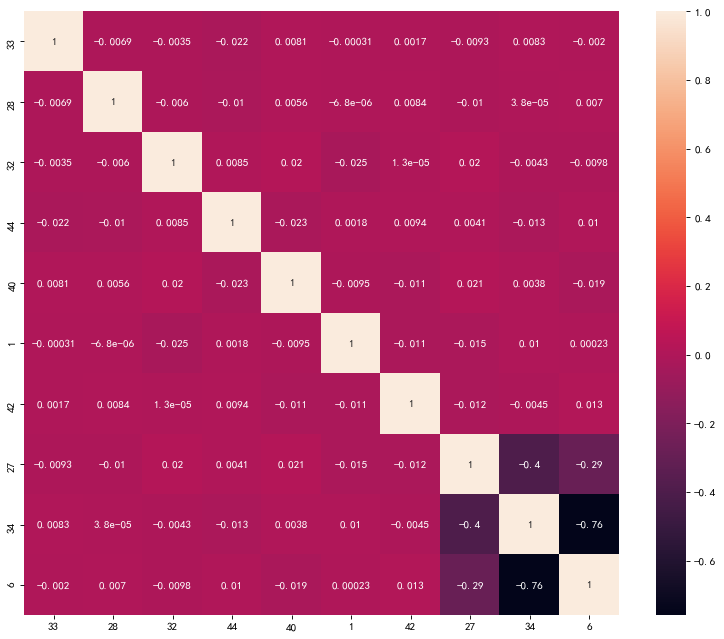

In [27]:
"""
去除相关度高（冗余）的特征，特征较少时可以用画图的方式
我们选择与标签最相关的10特征
"""
df_2 = df[corr_y.sort_values(ascending=True)[-11:-1].index]

figure(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
corr_2 = df_2.corr()
sns.heatmap(corr_2, annot=True, fmt=".2g")

In [28]:
"""
特征6 和 特征34 高度相关，特征27 和 特征34 也比较相关，我们去掉特征34
特征6 和 特征27 也比较为相关，可以尝试去除特征6
"""
print("10个特征")
keep_features = corr_y.sort_values(ascending=True)[-11:-1].index  # 去掉y
keep_features = keep_features.values.astype(np.int64)              # 变为int类型

clf = LogisticRegression(random_state=seed)
clf.fit(df[keep_features], y_train)
get_socre(y_test, clf.predict(X_test[:, keep_features]))

print("9个特征")
keep_features = np.delete(keep_features, [8, 9], axis=0)  # 34在第8个位置，6在第9位置
clf = LogisticRegression(random_state=seed)
clf.fit(df[keep_features], y_train)
get_socre(y_test, clf.predict(X_test[:, keep_features]))

10个特征
[+]F1 score :  0.9184968277208394
[+]acc score:  0.9165
9个特征
[+]F1 score :  0.527244421380384
[+]acc score:  0.5445


## L1正则
L1正则可以让模型的解更加稀疏，相当于做了特征选择

In [29]:
"""
直接使用L1正则作为惩罚项
"""
clf = LogisticRegression(random_state=seed, solver='saga', penalty='l1')  # 大多默认使用L2正则，默认的solver不支持L1正则
clf.fit(X_train, y_train)
get_socre(y_test, clf.predict(X_test))

[+]F1 score :  0.9195514383227693
[+]acc score:  0.9175


In [30]:
# 可以看到有3个0分量，相当于只用了47个特征
clf.coef_

array([[-9.51245569e-03,  7.32183085e-02,  4.83180957e-03,
         4.30733017e-02,  0.00000000e+00, -4.66811406e-01,
         3.05351025e+00,  1.92057468e-02, -3.02207220e-03,
         1.71185771e-02, -1.79497466e-02,  1.50594500e-03,
        -2.35858507e-02, -1.56778248e-02, -8.13824619e-03,
         4.75994406e-02,  4.40293302e-02, -2.11428813e-02,
        -2.83840948e-02, -1.80366925e-02, -2.66550994e-02,
        -6.08503882e-02,  0.00000000e+00, -4.66328823e-02,
        -3.07754761e-02,  3.51362465e-02,  3.12259683e-02,
        -3.95710526e-01,  4.51142572e-02, -2.08816937e-03,
         3.92244686e-02,  6.06499896e-02,  9.42245903e-03,
         5.29337953e-02,  0.00000000e+00, -3.15209645e-02,
        -3.49550033e-02, -2.57010991e-02,  1.97250041e-02,
         5.36825749e-02, -2.26434646e-03, -1.59557488e-02,
         4.38363779e-02,  2.59519955e-02,  4.01781929e-02,
         6.45112216e-02,  9.37199646e-02, -9.79968706e-03,
        -3.26383784e-02, -6.34598643e-03]])

In [31]:
clf = LogisticRegression(random_state=seed, solver='saga', penalty='l2')  # 使用L2正则作为对照
clf.fit(X_train, y_train)
get_socre(y_test, clf.predict(X_test))

[+]F1 score :  0.9185763042418332
[+]acc score:  0.9165


In [32]:
# L1正则的解比L2正则的稀疏
# 这里使用L2正则就没有0分量
clf.coef_

array([[-1.08921100e-02,  7.48467989e-02,  6.26940633e-03,
         4.46747399e-02, -1.25052588e-03, -6.61374591e-01,
         2.53943109e+00,  2.08043212e-02, -4.31963267e-03,
         1.86689835e-02, -1.94129903e-02,  2.97867411e-03,
        -2.50700197e-02, -1.68370235e-02, -9.64746755e-03,
         4.90329505e-02,  4.52764233e-02, -2.31655798e-02,
        -2.98308541e-02, -1.95454371e-02, -2.79398592e-02,
        -6.20594534e-02,  1.78168377e-03, -4.82334054e-02,
        -3.20009028e-02,  3.67419561e-02,  3.30389727e-02,
        -8.99388533e-01,  4.65904247e-02, -3.49941446e-03,
         4.08514183e-02,  6.22428361e-02,  1.11832246e-02,
         5.44403237e-02, -8.42321704e-01, -3.28235687e-02,
        -3.61683319e-02, -2.72109912e-02,  2.12362903e-02,
         5.54439459e-02, -3.76669583e-03, -1.76304242e-02,
         4.52219803e-02,  2.75392075e-02,  4.15925722e-02,
         6.57780799e-02,  9.51320196e-02, -1.14884322e-02,
        -3.39432636e-02, -7.98007378e-03]])

In [40]:
clf = LogisticRegression(random_state=seed, solver='saga', penalty='none')  # 不使用惩罚项作为对照
clf.fit(X_train, y_train)
get_socre(y_test, clf.predict(X_test))
clf.coef_

[+]F1 score :  0.9190243902439025
[+]acc score:  0.917


array([[-1.09291020e-02,  7.51816545e-02,  6.21075872e-03,
         4.49933765e-02, -1.32496087e-03, -6.65089007e-01,
         2.55168233e+00,  2.09757028e-02, -4.38317029e-03,
         1.89730198e-02, -1.95811006e-02,  2.88288167e-03,
        -2.52665511e-02, -1.69769621e-02, -9.67406704e-03,
         4.94252961e-02,  4.56604886e-02, -2.33097291e-02,
        -3.00064236e-02, -1.96306150e-02, -2.81423660e-02,
        -6.24040447e-02,  1.72615918e-03, -4.85314639e-02,
        -3.20968120e-02,  3.69763984e-02,  3.31646931e-02,
        -9.03969915e-01,  4.68198081e-02, -3.50570308e-03,
         4.09494008e-02,  6.25825239e-02,  1.14700497e-02,
         5.46637854e-02, -8.46118899e-01, -3.30439900e-02,
        -3.63456020e-02, -2.73710935e-02,  2.14092321e-02,
         5.58930136e-02, -3.71554623e-03, -1.77930800e-02,
         4.53222228e-02,  2.77130824e-02,  4.17473178e-02,
         6.62082406e-02,  9.57603189e-02, -1.16069695e-02,
        -3.42077415e-02, -8.11364465e-03]])

In [33]:
"""
L1正则作特征选择，画图看重要性（系数大小）
"""
from sklearn.linear_model import LassoCV

clf = LogisticRegression(random_state=seed, solver='saga', penalty='l1')
clf.fit(X_train, y_train)

print("消除特征数：", len(clf.coef_[clf.coef_==0]))
print("保留特征数：", len(clf.coef_[clf.coef_!=0])) 

消除特征数： 3
保留特征数： 47


Text(0.5, 1.0, '使用Lasso获得特征的重要性（不为0的系数）')

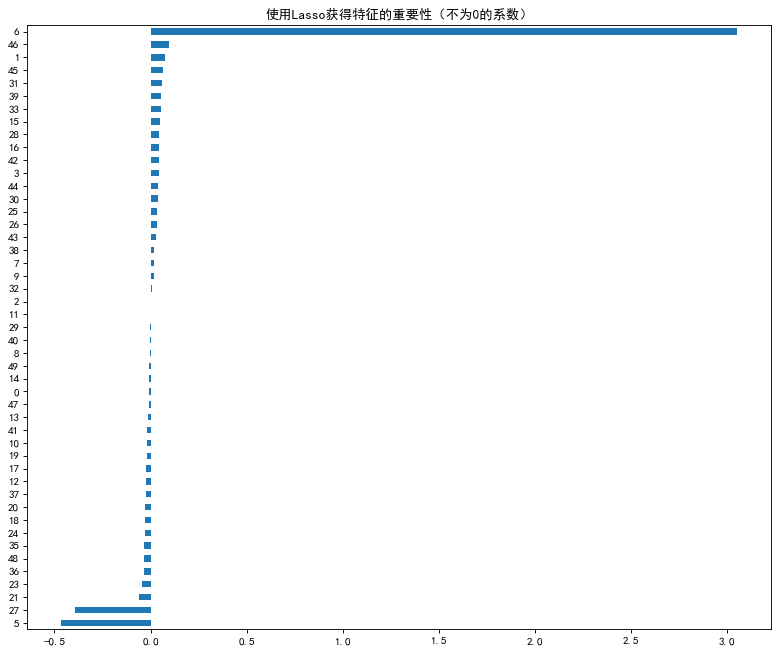

In [34]:
model_coef = pd.Series(clf.coef_.reshape(-1))
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
top_coef = model_coef.sort_values()
top_coef[top_coef != 0].plot(kind = "barh")
plt.title("使用Lasso获得特征的重要性（不为0的系数）")

# PCA降维
使用奇异值分解将数据投影到较低的k维空间，这k维特征被称为主成份  

参考文章：https://www.jianshu.com/p/bcd196497d94  

In [35]:
# 画图看降到多少维合适
from sklearn.decomposition import PCA
candidate_components = range(5, 50, 5)  # 有50个特征，我们最低取5维，并以5为步长递增
explained_ratios = []
for c in candidate_components:
    pca = PCA(n_components=c)
    pca.fit(X_train)
    explained_ratios.append(np.sum(pca.explained_variance_ratio_))
print(explained_ratios)

[0.16078459373927048, 0.2652297979042278, 0.36983423462781223, 0.4707614443558456, 0.5699266896524299, 0.669319129162304, 0.7667601514569581, 0.8607271129195249, 0.9489175018749659]


([<matplotlib.axis.XTick at 0x118e61053c8>,
 <a list of 10 Text xticklabel objects>)

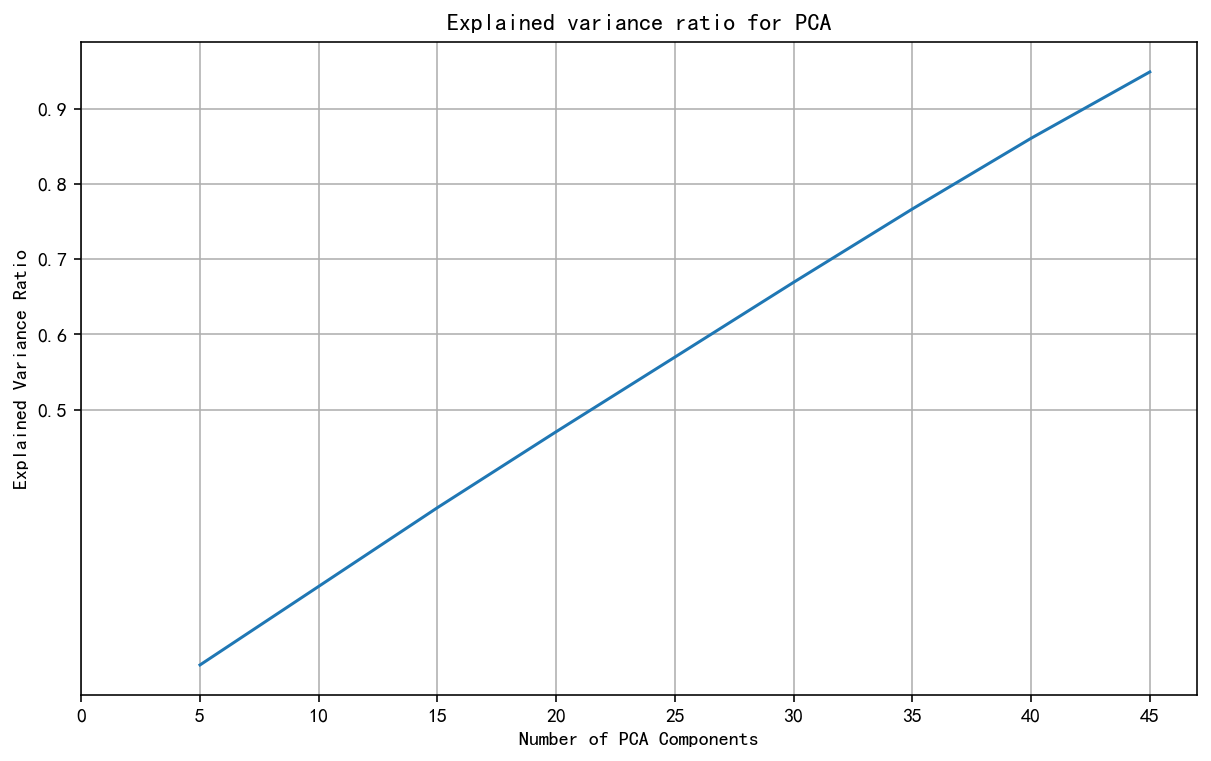

In [36]:
plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.plot(candidate_components, explained_ratios)
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained variance ratio for PCA')
plt.yticks(np.arange(0.5, 1, 0.1))
plt.xticks(np.arange(0, 50, 5))

In [37]:
"""
发现图是线性的，没有明显拐点，尽量选择方差百分比高的主成分数
40占所有特征的方差百分比为0.8607271129195249
"""
pca = PCA(n_components=40)
X_new_train = pca.fit_transform(X_train)
X_new_test = pca.transform(X_test)
clf = LogisticRegression(random_state=seed)
clf.fit(X_new_train, y_train)
get_socre(y_test, clf.predict(X_new_test))

[+]F1 score :  0.919921875
[+]acc score:  0.918


In [38]:
"""
45占所有特征的方差百分比为0.9489175018749659
"""
pca = PCA(n_components=45)
X_new_train = pca.fit_transform(X_train)
X_new_test = pca.transform(X_test)
clf = LogisticRegression(random_state=seed)
clf.fit(X_new_train, y_train)
get_socre(y_test, clf.predict(X_new_test))

[+]F1 score :  0.9208984375
[+]acc score:  0.919
